In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **One Hot** **Encoding**

In [ ]:
import numpy as np
import pandas as pd
import pickle

In [ ]:
data = pickle.load(open('/content/drive/MyDrive/Minor Project/30music.pkl', 'rb')).rename(columns = {'UserId': 'user_id', 'SessionId': 'session_id', 'ItemId': 'song_id', 'Time': 'time', 'ArtistId': 'artist_id'})
data.head(5)

,user_id,session_id,song_id,time,artist_id
0,27063,1889046,2691760,1402997433,337496
1,27063,1889046,2691717,1402997784,337496
2,27063,1889046,2691636,1402998064,337496
3,27063,1889046,2691702,1402998298,337496
4,27063,1889046,2691783,1402998576,337496


In [ ]:
words = list(data['song_id'].unique())

In [ ]:
len(data['song_id'].unique())

4522

In [ ]:
session_lengths = data.groupby('session_id').size()
data.shape, session_lengths

((6000, 5),
 session_id
 1047030     11
 1047034     11
 1072002     12
 1072005     12
 1072007      5
           ... 
 995801      40
 995802      14
 995803      11
 995804     121
 995805       4
 Length: 342, dtype: int64)

In [ ]:
data = data[np.in1d(data.session_id, session_lengths[session_lengths>1].index)]
item_supports = data.groupby('song_id').size()
data = data[np.in1d(data.song_id, item_supports[item_supports>=5].index)]
session_lengths = data.groupby('session_id').size()
data1 = data[np.in1d(data.session_id, session_lengths[session_lengths>=2].index)]

In [ ]:
groups = data1.groupby('session_id')
aggregated = groups['song_id'].agg(sequence = lambda x: list(map(str, x)))
init_ts = groups['time'].min()
users = groups['user_id'].min()
data = aggregated.join(init_ts).join(users)
data.reset_index(inplace=True)
data.head()

,session_id,sequence,time,user_id
0,1072002,"[314212, 136742]",1395868047,21212
1,1072005,"[314212, 314212, 314212]",1395931174,21212
2,1072041,"[1326519, 1326519, 1326519, 1326519, 1326519, ...",1413223078,21212
3,1072042,"[2114962, 1326011, 1326011, 1326011, 2114962, ...",1414338820,21212
4,1072043,"[3765734, 3765734, 3765734, 3765734, 3765734]",1414347903,21212


In [ ]:
from collections import Counter
cnt = Counter()
data.sequence.map(cnt.update)

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
Name: sequence, dtype: object

In [ ]:
sequence_length = data.sequence.map(len).values
n_sessions_per_user = data.groupby('user_id').size()

In [ ]:
print('Number of items: {}'.format(len(cnt)))
print('Number of users: {}'.format(data.user_id.nunique()))
print('Number of sessions: {}'.format(len(data)))
print('\nSession length:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    sequence_length.mean(), 
    np.quantile(sequence_length, 0.5), 
    sequence_length.min(), 
    sequence_length.max()))
print('Sessions per user:\n\tAverage: {:.2f}\n\tMedian: {}\n\tMin: {}\n\tMax: {}'.format(
    n_sessions_per_user.mean(), 
    np.quantile(n_sessions_per_user, 0.5), 
    n_sessions_per_user.min(), 
    n_sessions_per_user.max()))

Number of items: 51
Number of users: 15
Number of sessions: 45

Session length:
	Average: 7.42
	Median: 4.0
	Min: 2
	Max: 67
Sessions per user:
	Average: 3.00
	Median: 2.0
	Min: 1
	Max: 11


In [ ]:
dictList = data['sequence']
for i in range(0,len(dictList)):
        if len(dictList[i])<6:
            w=6-len(dictList[i])
            dictList[i]=['10000']*w+dictList[i]

data['sequence'] = dictList

data.head()

,session_id,sequence,time,user_id
0,1072002,"[10000, 10000, 10000, 10000, 314212, 136742]",1395868047,21212
1,1072005,"[10000, 10000, 10000, 314212, 314212, 314212]",1395931174,21212
2,1072041,"[1326519, 1326519, 1326519, 1326519, 1326519, ...",1413223078,21212
3,1072042,"[2114962, 1326011, 1326011, 1326011, 2114962, ...",1414338820,21212
4,1072043,"[10000, 3765734, 3765734, 3765734, 3765734, 37...",1414347903,21212


In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
x = []
for l in data['sequence']:
  for e in l:
    x.append(e)
x = list(set(x))

In [ ]:
if '10000' in x:
  print('YES')

YES


In [ ]:
m = {}
for i, w in enumerate(x):
  m[w] = i

In [ ]:
def get_vector(unq, i):
  lst = [0 for j in range(unq)]
  lst[i] = 1
  return lst

In [ ]:
a = data['sequence']
one_hot = []
for i in range(len(a)):
    # print(str(i)+':')
    seq = a[i]
    seq_vector = []
    for j in range(len(seq)):
        # print(j)
        item = seq[j]
        seq_vector.append(get_vector(len(words), m[item]))
    one_hot.append(seq_vector)

data['one_hot'] = one_hot

In [ ]:
X = []

for i in range(len(one_hot)):
    seq = one_hot[i]
    if len(seq)>= 5:
        for j in range(0,(len(seq)-5)):  
            X.append(seq[j:j+5])
            #y.append(seq[j+5])

X = np.array(X)

X.shape

(195, 5, 4522)

In [ ]:
v = data['sequence'].tolist()
y = []
for i in range(len(v)):
    seq = v[i]
    if len(seq)>= 5:
        for j in range(0,(len(seq)-5)):  
            #X.append(seq[j:j+5])
            y.append(seq[j+5])

In [ ]:
y = list(map(int, y))
label_encoding_data = list(m)
from sklearn.preprocessing import LabelEncoder
product_label=LabelEncoder()
product_label.fit(label_encoding_data)
y = product_label.transform(y)

type(y), max(y)

(numpy.ndarray, 51)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten,Reshape
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
import tensorflow as tf
from keras.models import Model

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
n_steps=5
n_features=50
batch_size=32
total_vocab=len(m)

In [ ]:
# define model
# vertical_model = Sequential()
first_input = Input(shape=(n_steps, n_features, 1))
vertical_model = Conv2D(filters=512, kernel_size=(5,1), activation='relu', padding='valid')(first_input)
vertical_model = Reshape(target_shape = (vertical_model.shape[2], vertical_model.shape[3]))(vertical_model)
vertical_model = MaxPooling1D(pool_size = vertical_model.shape[1])(vertical_model)
vertical_model = Flatten()(vertical_model)

# horizontal_model = Sequential()
second_input = Input(shape=(n_steps, n_features, 1))
horizontal_model = Conv2D(filters=512, kernel_size=(3,50), activation='relu', padding='valid')(second_input)
# print(horizontal_model.shape)
horizontal_model = Reshape(target_shape = (horizontal_model.shape[1]*horizontal_model.shape[2], horizontal_model.shape[3]))(horizontal_model)
horizontal_model = MaxPooling1D(pool_size = horizontal_model.shape[1])(horizontal_model)
horizontal_model = Flatten()(horizontal_model)

# merge_model = Sequential()
merged = tf.keras.layers.Concatenate()([vertical_model, horizontal_model])
# merge_model.add(merged)

merge_model = Dense(256, activation='relu')(merged)
merge_model = Dense(64, activation='relu')(merged)
merge_model = Dense(total_vocab, activation='softmax')(merge_model)
model = Model(inputs = [first_input, second_input], outputs = merge_model)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 3, 1, 512)         77312     
                                                                 
 reshape_1 (Reshape)         (None, 3, 512)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 512)           0         
 )                                                               
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 50)                25650     
                                                                 
 dense_9 (Dense)             (None, 52)                2652      
                                                      

In [ ]:
# fit model
history = model.fit([X_train, X_train], 
          y_train, 
          epochs=50,
          validation_split=0.1,
          verbose=2)

Epoch 1/35
4/4 - 5s - loss: 3.9108 - accuracy: 0.0968 - val_loss: 3.8152 - val_accuracy: 0.0312 - 5s/epoch - 1s/step
Epoch 2/35
4/4 - 3s - loss: 3.8172 - accuracy: 0.0887 - val_loss: 3.7780 - val_accuracy: 0.0312 - 3s/epoch - 732ms/step
Epoch 3/35
4/4 - 3s - loss: 3.7295 - accuracy: 0.1290 - val_loss: 3.6514 - val_accuracy: 0.0312 - 3s/epoch - 764ms/step
Epoch 4/35
4/4 - 5s - loss: 3.6731 - accuracy: 0.0887 - val_loss: 3.5978 - val_accuracy: 0.0625 - 5s/epoch - 1s/step
Epoch 5/35
4/4 - 3s - loss: 3.5513 - accuracy: 0.1694 - val_loss: 3.6004 - val_accuracy: 0.1875 - 3s/epoch - 741ms/step
Epoch 6/35
4/4 - 3s - loss: 3.4241 - accuracy: 0.2097 - val_loss: 3.5121 - val_accuracy: 0.0312 - 3s/epoch - 731ms/step
Epoch 7/35
4/4 - 3s - loss: 3.3353 - accuracy: 0.0968 - val_loss: 3.4407 - val_accuracy: 0.0938 - 3s/epoch - 733ms/step
Epoch 8/35
4/4 - 4s - loss: 3.1734 - accuracy: 0.2661 - val_loss: 3.3298 - val_accuracy: 0.2812 - 4s/epoch - 1s/step
Epoch 9/35
4/4 - 4s - loss: 3.0206 - accuracy: 0.

In [ ]:
import matplotlib.pyplot as plt

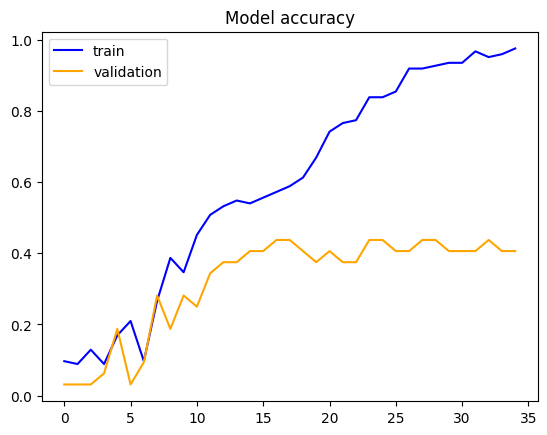

In [ ]:
plt.plot(np.arange(len(history.history['accuracy'])), history.history['accuracy'], color='blue')
plt.plot(np.arange(len(history.history['val_accuracy'])), history.history['val_accuracy'], color='orange')
plt.legend(['train', 'validation'])
plt.title('Model accuracy')
plt.show()

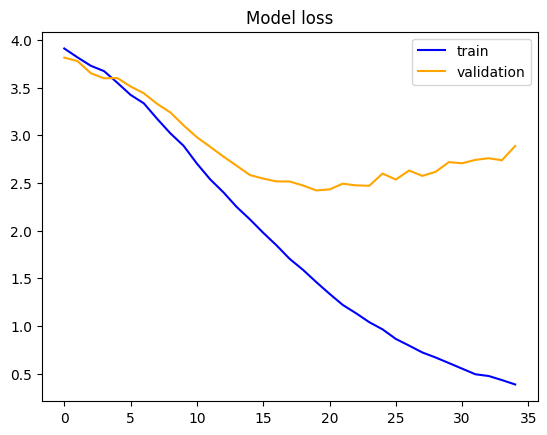

In [ ]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], color='blue')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], color='orange')
plt.legend(['train', 'validation'])
plt.title('Model loss')
plt.show()